#### Подключение библиотек

In [10]:
# import libraries
import cv2

# Загружаем обученный каскад классификатор
eye_detect = cv2.CascadeClassifier('haarcascade_eye.xml')

# Обработка заранее заготовленного видеорда

In [12]:
# Запускаем камеру / читаем видео
video = cv2.VideoCapture('video/KFU.mp4')

while True:
    
    # Читаем кадр/изображение из камеры
    resp, frame = video.read()
    
    # если нет кадра, то прерываем цикл
    if resp==0:
        break
        
    # Преобразуем цветное изображение в оттенки серого
    gray_img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Обнаруживаем область ROИ лиц
    #Синтаксис: Classifier.detectMultiScale(входное изображение, Масштаб Фактор, Минимальное Соседство)
    eyes = eye_detect.detectMultiScale(gray_img, 1.3, 7)
    
    # Рисуем прямоугольник вокруг обнаруженных лиц
    for (x,y,w,h) in eyes:
        cv2.rectangle(frame, (x,y), (x+w, y+h), (0,0,255), 3)
    
    # Отображаем изображение
    cv2.imshow('RealTime обнаружение глаз', frame)  
    
    #ожидаем нажатия клавиши
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
# освобождаем камеру/веб-камеру   
video.release()

# закрываем все окна
cv2.destroyAllWindows()


# Обработка видео в RealTime


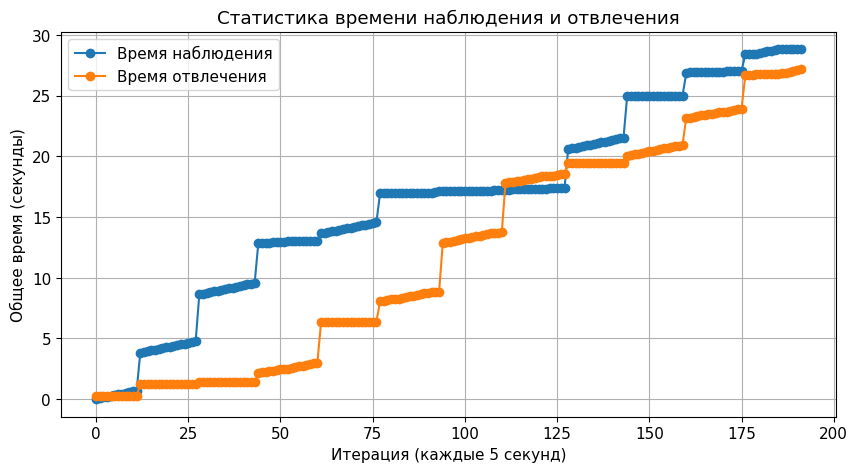

In [ ]:
import cv2
import time
import matplotlib.pyplot as plt

# Включаем отображение графиков в Jupyter Notebook
%matplotlib inline

# Загрузка стандартного каскад классификатора для глаз
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

# Инициализация веб-камеры
cap = cv2.VideoCapture(0)

# Переменные для статистики
time_observing = 0  # Время наблюдения за экраном
time_distracted = 0  # Время отвлечения
start_time = time.time()  # Время начала наблюдения

# Списки для хранения данных
observing_times = []
distracted_times = []

try:
    while True:
        # Чтение кадра из веб-камеры
        ret, frame = cap.read()
        
        if not ret:
            print("Ошибка при чтении кадра")
            continue

        # Преобразование цветного изображения в оттенки серого
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Обнаружение глаз
        eyes = eye_cascade.detectMultiScale(
            gray,
            scaleFactor=1.1,
            minNeighbors=5,
            minSize=(30, 30)
        )

        # Проверка, были ли обнаружены глаза
        if len(eyes) > 0:
            time_observing += time.time() - start_time
            start_time = time.time()  # Обновляем время начала наблюдения
        else:
            time_distracted += time.time() - start_time
            start_time = time.time()  # Обновляем время начала отвлечения

        # Рисование прямоугольников вокруг обнаруженных глаз
        for (x, y, w, h) in eyes:
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)

        # Отображение кадра
        cv2.imshow('Eye Detection', frame)

        # Ожидание нажатия клавиши
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

        # Сохранение данных для графика каждые 5 секунд
        if int(time_observing + time_distracted) % 5 == 0:
            observing_times.append(time_observing)
            distracted_times.append(time_distracted)

except KeyboardInterrupt:
    pass
finally:
    # Освобождение ресурсов
    cap.release()
    cv2.destroyAllWindows()

    # Построение графика
    plt.figure(figsize=(10, 5))
    plt.plot(observing_times, label='Время наблюдения', marker='o')
    plt.plot(distracted_times, label='Время отвлечения', marker='o')
    plt.xlabel('Итерация (каждые 5 секунд)')
    plt.ylabel('Общее время (секунды)')
    plt.title('Статистика времени наблюдения и отвлечения')
    plt.legend()
    plt.grid(True)
    plt.show()


# Улучшенный вариант с использованием обученой модели

In [7]:
import cv2
import numpy as np

# Загрузка YOLO модели для обнаружения лиц
net = cv2.dnn.readNet('yolov5_face.weights', 'yolov5_face.cfg')
layer_names = net.getLayerNames()
output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]

# Загрузка каскада классификатора для обнаружения глаз
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

# Инициализация веб-камеры
cap = cv2.VideoCapture(0)

try:
    while True:
        # Чтение кадра из веб-камеры
        ret, frame = cap.read()
        if not ret:
            print("Ошибка при чтении кадра")
            break

        # Подготовка изображения для YOLO
        blob = cv2.dnn.blobFromImage(frame, 1/255.0, (416, 416), swapRB=True, crop=False)
        net.setInput(blob)
        detections = net.forward(output_layers)

        boxes = []
        confidences = []
        for output in detections:
            for detection in output:
                scores = detection[5:]
                confidence = scores[0]  # YOLO v5 нацелена на обнаружение лиц
                if confidence > 0.5:
                    center_x, center_y, width, height = (
                        int(detection[0] * frame.shape[1]),
                        int(detection[1] * frame.shape[0]),
                        int(detection[2] * frame.shape[1]),
                        int(detection[3] * frame.shape[0]),
                    )
                    x = int(center_x - width / 2)
                    y = int(center_y - height / 2)
                    boxes.append([x, y, width, height])
                    confidences.append(float(confidence))

        # Подавление ненужных перекрытий
        indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
        detections = np.array([boxes[i] for i in indices.flatten()])

        for box in detections:
            x, y, w, h = box.astype(int)

            # Обрезаем область лица и преобразуем в оттенки серого для обнаружения глаз
            face_roi = frame[y:y+h, x:x+w]
            gray_face = cv2.cvtColor(face_roi, cv2.COLOR_BGR2GRAY)

            # Обнаружение глаз в пределах области лица
            eyes = eye_cascade.detectMultiScale(
                gray_face,
                scaleFactor=1.1,
                minNeighbors=5,
                minSize=(20, 20)
            )

            # Рисование прямоугольника вокруг лица
            cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)

            # Рисование прямоугольников вокруг обнаруженных глаз
            for (ex, ey, ew, eh) in eyes:
                cv2.rectangle(face_roi, (ex, ey), (ex + ew, ey + eh), (0, 255, 0), 2)

        # Отображение кадра
        cv2.imshow('Face and Eye Detection', frame)

        # Ожидание нажатия клавиши
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

except KeyboardInterrupt:
    pass
finally:
    # Освобождение ресурсов
    cap.release()
    cv2.destroyAllWindows()
